In [1]:
!pip install torch torchvision timm matplotlib seaborn numpy scikit-learn


In [3]:
import os
import zipfile

zip_path = "/content/archive (2).zip"  # Adjust if the filename is different
extract_path = "/content/Data"

# Extract ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content")

# Verify extraction
print("Extracted files:", os.listdir("/content"))


Extracted files: ['.config', 'Data', 'archive (2).zip', 'sample_data']


In [4]:
import os

dataset_path = "/content/Data"
if not os.path.exists(dataset_path):
    print("❌ Dataset folder not found! Check your extraction path.")
else:
    print("📂 Folders inside dataset path:", os.listdir(dataset_path))


📂 Folders inside dataset path: ['train', 'test', 'valid']


In [5]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to MaxViT input size
    transforms.ToTensor(),           # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])


In [6]:
from torchvision import datasets
from torch.utils.data import DataLoader

train_dataset = datasets.ImageFolder(f"{dataset_path}/train", transform=transform)
valid_dataset = datasets.ImageFolder(f"{dataset_path}/valid", transform=transform)
test_dataset = datasets.ImageFolder(f"{dataset_path}/test", transform=transform)

batch_size = 16  # Adjust batch size based on GPU memory

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_classes = len(train_dataset.classes)
print("✅ Number of classes:", num_classes)
print("✅ Class names:", train_dataset.classes)


✅ Number of classes: 4
✅ Class names: ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']


In [7]:
import timm
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available

# Load MaxViT model
model = timm.create_model("maxvit_tiny_rw_224", pretrained=True, num_classes=num_classes)
model = model.to(device)  # Move model to GPU


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/116M [00:00<?, ?B/s]

In [8]:
criterion = nn.CrossEntropyLoss()  # Classification loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)  # Optimizer


In [9]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        # --- Training phase ---
        model.train()
        train_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        train_loss = train_loss / len(train_loader)

        # --- Validation phase ---
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0

        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_acc = 100 * val_correct / val_total
        val_loss = val_loss / len(valid_loader)

        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% - "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    return model


In [10]:
model = train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=10)


Epoch [1/10] - Train Loss: 0.8819, Train Acc: 61.50% - Val Loss: 0.8600, Val Acc: 58.33%
Epoch [2/10] - Train Loss: 0.3622, Train Acc: 86.13% - Val Loss: 0.8420, Val Acc: 66.67%
Epoch [3/10] - Train Loss: 0.1497, Train Acc: 95.27% - Val Loss: 0.4289, Val Acc: 84.72%
Epoch [4/10] - Train Loss: 0.0396, Train Acc: 98.86% - Val Loss: 0.1806, Val Acc: 91.67%
Epoch [5/10] - Train Loss: 0.0711, Train Acc: 98.21% - Val Loss: 0.3269, Val Acc: 87.50%
Epoch [6/10] - Train Loss: 0.0391, Train Acc: 98.69% - Val Loss: 0.5064, Val Acc: 83.33%
Epoch [7/10] - Train Loss: 0.0852, Train Acc: 97.23% - Val Loss: 0.2480, Val Acc: 91.67%
Epoch [8/10] - Train Loss: 0.0681, Train Acc: 97.72% - Val Loss: 0.5641, Val Acc: 77.78%
Epoch [9/10] - Train Loss: 0.0190, Train Acc: 99.18% - Val Loss: 0.4493, Val Acc: 90.28%
Epoch [10/10] - Train Loss: 0.0613, Train Acc: 99.18% - Val Loss: 0.2529, Val Acc: 87.50%


In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    return y_true, y_pred


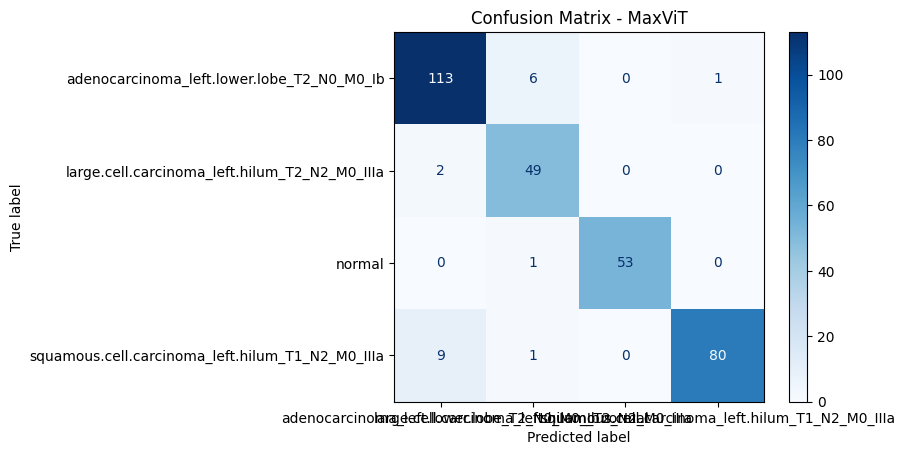

In [12]:
y_true, y_pred = evaluate_model(model, test_loader)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix - MaxViT")
plt.show()


In [13]:
torch.save(model.state_dict(), "maxvit_model.pth")
print("✅ Model saved successfully!")


✅ Model saved successfully!


In [14]:
model.load_state_dict(torch.load("maxvit_model.pth"))
model.eval()
print("✅ Model loaded successfully!")


✅ Model loaded successfully!
